# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS-109A Introduction to Data Science 


## Fine Particulate Air Pollution and COVID-19

**Harvard University**<br>
**Spring 2020**<br>
Jack Luby, Hakeem Angulu, and Louie Ayre <br>

---



### The Problem

Fine particulate matter (PM$_{2.5}$) is an air pollutant which has been shown to increase the risk of mortality and hospitalization in exposed populations. 

The fine inhalable particles of PM$_{2.5}$ impact communitites at the local level, incrementally decreasing their life expectancies as ambient concentrations of the pollutant rise. Despite their adverse effects, concentrations of PM$_{2.5}$ are not well monitored throughout much of the United States (especially in regions of low population density). As a result, many communities (and their care providers) are unaware of the life-shortening ambient concentrations of PM$_{2.5}$ they breathe each day. 

These risks have been heightened by the coronavirus pandemic. COVID-19 is primarily a respiratory disease, and PM$_{2.5}$'s adverse effects on respiratory potential have been theorized and shown to increase the likelihood of developing COVID-19. It is apparent that high concentrations of PM$_{2.5}$ are likely to be founded in rural and low-income communities and communities of color. In addition, the US healthcare and social systems have long underserved those communities. The combination of these factors creates an especially bad prognosis for those communities, and necessitates further study and rapid policy and healthcare interventions.

### Our Project

With PM$_{2.5}$ data and COVID-19 data at hand, this project seeks to understand the relationships between PM$_{2.5}$ pollution, demographic and socioeconomic factors, and COVID-19, with a particular focus on rural and low-income communities, and communities of color.

# Feed Forward Neural Network Modeling and Analysis

In [2]:
## Set formatting to CS109 standard
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [1]:
# The classics
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt

In [3]:
# Neural Network imports
import tensorflow as tf

from tensorflow.keras import backend
from tensorflow.keras.models import model_from_json

print(tf.keras.__version__)
print(tf.__version__)

2.2.4-tf
2.1.0


## Data Import

In [83]:
main_df = pd.read_csv("data/unnormalized.csv")

In [84]:
main_df.head()

,fips,pm25,poverty,pop_density,med_house_value,pct_blk,med_household_income,pct_owner_occ,pct_hispanic,education,...,days_since_shelter_in_place,days_since_closing_non-essential_businesses,religious_gatherings_exempt,liquor_stores_open,firearms_sellers_open,days_since_closing_restaurants_except_takeout,days_since_closing_gyms,days_since_closing_movie_theaters,froze_evictions,order_freezing_utility_shutoffs
0,1001,8.548029,0.153784,92.859925,147900.0,0.191395,58786.0,0.748946,0.027681,0.201884,...,36,43,0,1,1,52,43,43,0,0
1,1003,7.522474,0.105661,130.901888,189800.0,0.094970,55962.0,0.736193,0.044943,0.182423,...,36,43,0,1,1,52,43,43,0,0
2,1005,8.085884,0.288633,29.132136,92900.0,0.475758,34186.0,0.613978,0.042898,0.315394,...,36,43,0,1,1,52,43,43,0,0
3,1007,8.746719,0.139877,36.190198,96500.0,0.222755,45340.0,0.750731,0.024282,0.244739,...,36,43,0,1,1,52,43,43,0,0
4,1009,8.215674,0.144003,89.395550,124700.0,0.014954,48695.0,0.786262,0.091266,0.268941,...,36,43,0,1,1,52,43,43,0,0


In [85]:
responses = ['confirmed_covid_cases', 'covid_deaths', 'covid_recoveries']

X_train, X_test, y_train, y_test = train_test_split(main_df.drop(responses + ['fips'], axis=1),
                                                    main_df[responses], test_size=0.2,
                                                    random_state=109)

In [86]:
X_train.shape

(2272, 27)

In [87]:
y_train.shape

(2272, 3)

## Model Definition

In [220]:
# Hyperparameters
n_predictors = X_train.shape[-1]
n_responses = y_train.shape[-1]
drop_rate = .1

optimizer = "adam"
loss = "mse"
metrics = ["accuracy"]

batch_size = 1
epochs = 15
validation_split = 0.1
verbose = 2

In [221]:
# Define model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(n_predictors, activation="relu", input_dim=27))
model.add(tf.keras.layers.Dropout(drop_rate))
model.add(tf.keras.layers.Dense(n_responses, activation="linear"))

# Compile model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [222]:
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 27)                756       
_________________________________________________________________
dropout_23 (Dropout)         (None, 27)                0         
_________________________________________________________________
dense_57 (Dense)             (None, 3)                 84        
Total params: 840
Trainable params: 840
Non-trainable params: 0
_________________________________________________________________


## Model Training

In [216]:
# Define early stopping callback
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

In [249]:
# Don't re-train
# history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
#                     validation_split=validation_split, verbose=verbose)

## Model Analysis

In [239]:
# Plot history
def plot_loss(history):
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(12, 8))
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'b--', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

In [238]:
# Plot history
def plot_accuracy(history):
    accuracy = history['accuracy']
    val_accuracy = history['val_accuracy']
    epochs = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 8))
    plt.plot(epochs, accuracy, 'g-', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'g--', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

In [203]:
# Store model
def store_keras_model(model, model_name):
    model_json = model.to_json() # serialize model to JSON
    with open("./models/{}.json".format(model_name), "w") as json_file:
        json_file.write(model_json)
    model.save_weights("./models/{}.h5".format(model_name)) # serialize weights to HDF5
    print("Saved model to disk")
    
# Load model 
def load_keras_model(model_name):
    # Load json and create model
    json_file = open('./models/{}.json'.format(model_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = tf.keras.models.model_from_json(loaded_model_json)
    # Load weights into new model
    model.load_weights("./models/{}.h5".format(model_name))
    return model

In [251]:
# Save training history
# hist_df = pd.DataFrame(history.history)
# hist_df.to_csv("models/history_ffnn.csv", index=False)

In [250]:
# Save model
# store_keras_model(model, 'model_FFNN')

In [246]:
# Load history
history = pd.read_csv("models/history_ffnn.csv")

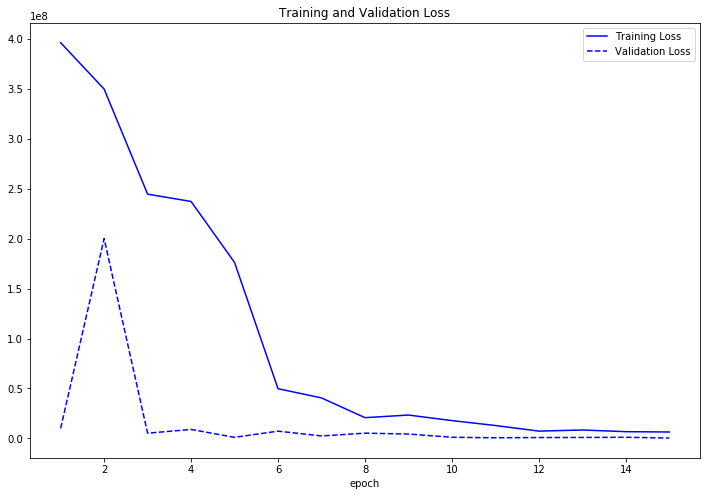

In [247]:
plot_loss(history)

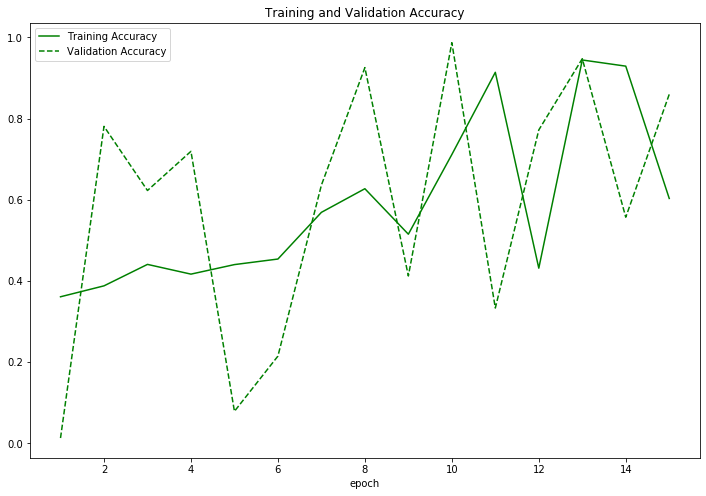

In [248]:
plot_accuracy(history)

In [260]:
# Load model
model = load_keras_model("model_FFNN")

In [261]:
predicted_cols = ['predicted_' + x for x in ['confirmed', 'deaths', 'recoveries']]

In [262]:
model_predictions = pd.DataFrame(model.predict(X_test), columns=predicted_cols)
test_results = pd.concat([model_predictions, y_test.reset_index(drop=True)], axis=1)

In [263]:
test_results

,predicted_confirmed,predicted_deaths,predicted_recoveries,confirmed_covid_cases,covid_deaths,covid_recoveries
0,-33.632271,-7.558352,-57.783115,15,0,0
1,474.062164,97.848793,-41.271408,28,0,0
2,156.811905,32.380405,11.580235,39,0,0
3,0.096133,-0.199398,-0.261109,2,0,0
4,803.948303,166.925751,62.299843,37,2,0
...,...,...,...,...,...,...
564,43.798534,8.652936,-33.858593,14,0,0
565,1324.771362,275.666351,175.479385,31,4,0
566,2632.350586,547.796814,321.232513,685,46,0
567,236.099838,48.823139,11.154905,35,0,0


## SHAP Analysis

### 